In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)


class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self):
        mnist_train = datasets.MNIST(root='./mnist_data/', train=True, download=True)
        self.data = mnist_train.data.reshape(-1, 784).float() / 255.0

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = MnistDataSet()

Fri Jan 15 10:26:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!






In [2]:
def rp(mu, lv):
    return mu + torch.exp(0.5 * lv) * torch.randn_like(mu)

def KLD_normals(mu1, lv1, mu2, lv2):
    kld = lv2 - lv1 + (torch.exp(lv1) + ((mu1 - mu2)**2))/torch.exp(lv2) - 1.0
    return 0.5 * kld

def RATE_normals(mu, lv):
    kld = - lv + torch.exp(lv) + (mu**2) - 1.0
    return 0.5 * kld


In [3]:
class FilterBank(object):
    def __init__(self, input_shape, N):
        self.nc, self.nh, self.nw = input_shape
        self.N = N
        self.di = torch.arange(0, self.N).to(device).float() - (self.N/2) - 0.5
        self.w = torch.arange(0, self.nw).to(device).float().view(1, -1).expand(self.N, -1)
        self.dj = torch.arange(0, self.N).to(device).float() - (self.N/2) - 0.5
        self.h = torch.arange(0, self.nh).to(device).float().view(1, -1).expand(self.N, -1)


    def toFxFy(self, gx, gy, delta, var):
        nb = gx.size(0)
        mu_x = (gx + self.di * delta).unsqueeze(dim=2).expand(-1, -1, self.nw)
        mu_y = (gy + self.dj * delta).unsqueeze(dim=2).expand(-1, -1, self.nh)
        Fx = (mu_x - self.w).pow(2)/(-2 * var.reshape(-1, 1, 1).expand(-1, self.N, self.nw))
        Fx = torch.exp(Fx)
        Fx = Fx/Fx.sum(dim=2, keepdim=True)
        Fy = (mu_y - self.h).pow(2)/(-2 * var.reshape(-1, 1, 1).expand(-1, self.N, self.nh))
        Fy = torch.exp(Fy)
        Fy = Fy/Fy.sum(dim=2, keepdim=True)
        Fx = Fx.unsqueeze(dim=1)
        Fy = Fy.unsqueeze(dim=1)
        if self.nc > 1:
            Fx = Fx.expand(-1, self.nc, -1, -1)
            Fy = Fy.expand(-1, self.nc, -1, -1)

        return Fx, Fy



class Draw(nn.Module):
    def __init__(self):
        super().__init__()
        N = 6
        z_size = 100
        enc_size = 400
        dec_size = 400
        input_shape = (1, 28, 28)

        self.N = N
        self.input_shape = input_shape
        self.enc = nn.LSTMCell(input_shape[0] * N * N * 2 + dec_size, enc_size)
        self.z_inf = nn.Linear(enc_size, z_size * 2)
        self.dec = nn.LSTMCell(z_size, dec_size)
        self.attention_params = nn.Linear(dec_size, 5)
        self.w = nn.Linear(dec_size, input_shape[0]*N*N)

        self.h0_enc = nn.Parameter(torch.zeros(1, enc_size))
        self.c0_enc = nn.Parameter(torch.zeros(1, enc_size))
        self.h0_dec = nn.Parameter(torch.zeros(1, dec_size))
        self.c0_dec = nn.Parameter(torch.zeros(1, dec_size))
        self.fb = FilterBank(input_shape, self.N)
        # self.vv = nn.Linear(dec_size, input_shape[0] * input_shape[1] * input_shape[2])



    def forward(self, x, T):
        nb, _ = x.size()
        h_enc = self.h0_enc.expand(nb, -1)
        c_enc = self.c0_enc.expand(nb, -1)
        h_dec = self.h0_dec.expand(nb, -1)
        c_dec = self.c0_dec.expand(nb, -1)
        canvas_curr = torch.zeros_like(x)
        canvas_seq = [canvas_curr]
        z_params = []
        for t in range(1, T):
            canvas_prev = canvas_seq[-1]
            x_hat = x - torch.sigmoid(canvas_prev)
            r_t = self.read(x, x_hat, h_dec)
            h_enc, c_enc = self.enc(torch.cat([r_t, h_dec], dim=1), (h_enc, c_enc))
            mu, lv = self.z_inf(h_enc).chunk(2, dim=1)
            z_params.append({'mu':mu, 'lv':lv})
            z = rp(mu, lv)
            h_dec, c_dec = self.dec(z, (h_dec, c_dec))
            canvas_curr = canvas_prev + self.write(h_dec)
            canvas_seq.append(canvas_curr)
        
        return torch.sigmoid(canvas_curr) , z_params


    def get_attention_params(self, h_dec):
        gx, gy, d, v, g = self.attention_params(h_dec).chunk(5, dim=1)
        gx = (self.input_shape[2] + 1) * (gx + 1) * 0.5
        gy = (self.input_shape[1] + 1) * (gy + 1) * 0.5
        d = ((max(self.input_shape[2], self.input_shape[1]) - 1)  / (self.N - 1) ) * torch.exp(d) 
        v = torch.exp(v)
        g = torch.exp(g)
        return gx, gy, d, v, g



    def read(self, x, x_hat, h_dec):
        gx, gy, d, v, g = self.get_attention_params(h_dec)
        Fx, Fy = self.fb.toFxFy(gx, gy, d, v)
        Fx = Fx.transpose(2, 3).contiguous()
        x = x.view(-1, self.input_shape[0], self.input_shape[1], self.input_shape[2])
        x_hat = x_hat.view(-1, self.input_shape[0], self.input_shape[1], self.input_shape[2])
        r_t = torch.cat([(Fy @ x @ Fx).flatten(1, -1), (Fy @ x_hat @ Fx).flatten(1, -1)], dim=1)
        r_t = r_t.flatten(1, -1) * g
        return r_t

    
    # def write(self, h_dec):
    #     return self.vv(h_dec)
    def write(self, h_dec):
        w = self.w(h_dec).view(-1, self.input_shape[0], self.N, self.N)
        gx, gy, d, v, g = self.get_attention_params(h_dec)
        Fx, Fy = self.fb.toFxFy(gx, gy, d, v)
        Fy = Fy.transpose(2, 3).contiguous()
        return (Fy @ w @ Fx).flatten(1, -1) / g


    def reconstruction(self, x, T):
        self.eval()
        nb, _ = x.size()
        h_enc = self.h0_enc.expand(nb, -1)
        c_enc = self.c0_enc.expand(nb, -1)
        h_dec = self.h0_dec.expand(nb, -1)
        c_dec = self.c0_dec.expand(nb, -1)
        canvas_curr = torch.zeros_like(x)
        canvas_seq = [canvas_curr]
        attention_params = []
        for t in range(1, T):
            canvas_prev = canvas_seq[-1]
            x_hat = x - torch.sigmoid(canvas_prev)
            r_t = self.read(x, x_hat, h_dec)
            gx, gy, d, v, g = self.get_attention_params(h_dec)
            h_enc, c_enc = self.enc(torch.cat([r_t, h_dec], dim=1), (h_enc, c_enc))
            mu, lv = self.z_inf(h_enc).chunk(2, dim=1)
            h_dec, c_dec = self.dec(rp(mu, lv), (h_dec, c_dec))
            canvas_curr = canvas_prev + self.write(h_dec)
            canvas_seq.append(canvas_curr)
            attention_params.append({'gx':gx, 'gy':gy, 'delta':d, 'var':v})
        self.train()
        return canvas_seq, attention_params


In [4]:
mbsz = 32
model = Draw().to(device)
solver = optim.Adam(model.parameters(), lr=5e-4)
loader = DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [5]:
num_epochs = 10


for epoch in range(num_epochs):
    RECON = 0.0
    KLD = 0.0

    for x_q in loader:
        solver.zero_grad()
        x_q = x_q.to(device).float()
        
        x_p, z_params = model(x_q, 16)
        
        recon = F.binary_cross_entropy(x_p, x_q, reduction='mean') * 784
        kld = 0
        for z_par in z_params:
            kld += RATE_normals(z_par['mu'], z_par['lv']).mean() * 100
        
        loss = recon + kld

        loss.backward()
        solver.step() 

        RECON += recon.item()
        KLD += kld.item()
    RECON /= (len(loader) * 784)
    KLD /= (len(loader) * 100)

    print(epoch, 'recon:', RECON, 'kld', KLD)

0 recon: 0.23142090956499786 kld 0.052954382753690084
1 recon: 0.16220149537170825 kld 0.1370723020324707
2 recon: 0.1390566381960499 kld 0.16681146820576986
3 recon: 0.12864989665543952 kld 0.1766278150177002
4 recon: 0.12141129673549107 kld 0.18158302066040038
5 recon: 0.11574085472781642 kld 0.1853187270965576
6 recon: 0.11192528579608113 kld 0.18876433280436197
7 recon: 0.10909129047004544 kld 0.19086254532877603
8 recon: 0.10710622503579069 kld 0.19283733973185221
9 recon: 0.10537042608974742 kld 0.1942440855407715


In [6]:
testdataset = datasets.MNIST(root='./mnist_data/', train=False, download=True).data.float() / 255.0

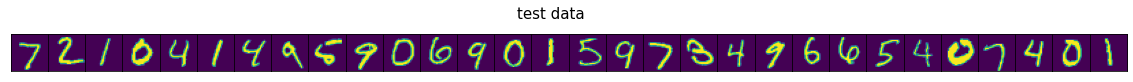

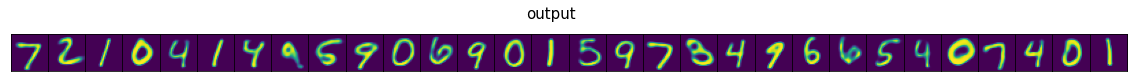

_


<Figure size 1440x144 with 0 Axes>

In [7]:
num_image = 30

fig = plt.figure(figsize=(20, 2))

n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(testdataset[n])
    n += 1
fig.suptitle('test data', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
n = 0
for i in range(num_image):
    x_q = testdataset[n].reshape(1, 784).float().to(device)
    x_p, _ = model(x_q, 25)
    x_p = x_p.reshape(28, 28).cpu().detach()
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(x_p.cpu().data.numpy().reshape(28, 28))
    n += 1
model.train()
fig.suptitle('output', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
print('_')

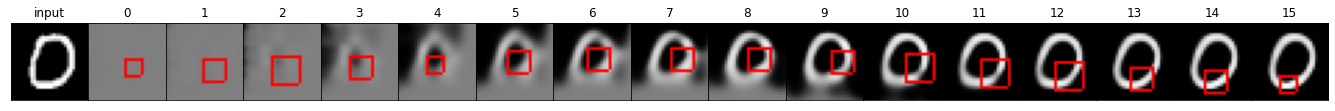

In [8]:
def reconstruction(x, T):
    model.eval()
    nb, _ = x.size()
    h_enc = model.h0_enc.expand(nb, -1)
    c_enc = model.c0_enc.expand(nb, -1)
    h_dec = model.h0_dec.expand(nb, -1)
    c_dec = model.c0_dec.expand(nb, -1)
    canvas_curr = torch.zeros_like(x)
    canvas_seq = [canvas_curr]
    attention_params = []
    for t in range(1, T):
        canvas_prev = canvas_seq[-1]
        x_hat = x - torch.sigmoid(canvas_prev)
        r_t = model.read(x, x_hat, h_dec)
        gx, gy, d, v, g = model.get_attention_params(h_dec)
        h_enc, c_enc = model.enc(torch.cat([r_t, h_dec], dim=1), (h_enc, c_enc))
        mu, lv = model.z_inf(h_enc).chunk(2, dim=1)
        h_dec, c_dec = model.dec(rp(mu, lv), (h_dec, c_dec))
        canvas_curr = canvas_prev + model.write(h_dec)
        canvas_seq.append(canvas_curr)
        attention_params.append({'gx':gx, 'gy':gy, 'delta':d, 'var':v})
    model.train()
    for i in range(len(canvas_seq)):
        canvas_seq[i] = torch.sigmoid(canvas_seq[i])
    return canvas_seq, attention_params



T = 16

x_q = testdataset[10].reshape(1, 784).float().to(device)
model.eval()


x_t, att = reconstruction(x_q, T + 1)
x_t.pop(0)
for i in range(len(x_t)):
    x_t[i] = x_t[i].cpu().detach().unsqueeze(0).reshape(1, 28, 28).expand(3, 28, 28).permute(1, 2, 0).numpy()
    x_t[i] = x_t[i].copy()
    gx = att[i]['gx'].unsqueeze(0).item()
    gy = att[i]['gy'].unsqueeze(0).item()
    delta = att[i]['delta'].unsqueeze(0).item()
    var = att[i]['var'].unsqueeze(0).item()
    delta = round(delta)
    gx = round(gx)
    gy = round(gy)
    for j in range(-delta, delta):

        if 0 <= gx + j and gx + j <28:
            if 0 <= gy + delta and gy + delta < 28:
                x_t[i][gy + delta][gx + j][0] = 1.0
                x_t[i][gy + delta][gx + j][1] = 0.0
                x_t[i][gy + delta][gx + j][2] = 0.0
            
            if 0 <= gy - delta and gy - delta < 28:
                x_t[i][gy - delta][gx + j][0] = 1.0
                x_t[i][gy - delta][gx + j][1] = 0.0
                x_t[i][gy - delta][gx + j][2] = 0.0


        if 0 <= gy + j and gy + j <28:
            if 0 <= gx + delta and gx + delta < 28:
                x_t[i][gy + j][gx + delta][0] = 1.0
                x_t[i][gy + j][gx + delta][1] = 0.0
                x_t[i][gy + j][gx + delta][2] = 0.0

            if 0 <= gx - delta and gx - delta < 28:
                x_t[i][gy + j][gx - delta][0] = 1.0
                x_t[i][gy + j][gx - delta][1] = 0.0
                x_t[i][gy + j][gx - delta][2] = 0.0



n = 1

fig = plt.figure(figsize=(25, 3))

_fig = fig.add_subplot(2, T + 2,  1, xticks=[], yticks=[])
_fig.set_title('input')
_fig.imshow(x_q.cpu().reshape(1, 28, 28).permute(1, 2, 0).expand(28, 28, 3).numpy())

for x in x_t:
    _fig = fig.add_subplot(2, T + 2, n + 1, xticks=[], yticks=[])
    _fig.set_title(str(n-1))
    _fig.imshow(x, cmap='ocean')
    n += 1

model.train()


plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
